<a href="https://colab.research.google.com/github/angeloken/Riset-I-smile/blob/main/riset_prediksi_listrik_ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [34]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [79]:
import pandas as pd
url_tr = 'https://drive.google.com/file/d/1jI7ukSaRReUFAUMeH2jDMJRhRd7AnWtk/view?usp=sharing'
path_tr = 'https://drive.google.com/uc?export=download&id='+url_tr.split('/')[-2]
train = pd.read_csv(path_tr)
url_tst = 'https://drive.google.com/file/d/1Wu56Cp5qDX9gPoPk5k5_zUTmV9u27aO-/view?usp=sharing'
path_tst = 'https://drive.google.com/uc?export=download&id='+url_tst.split('/')[-2]
test = pd.read_csv(path_tst)

In [80]:
train['date']=train['datetime'].str[:10]
train['date'] = pd.to_datetime(train['date'])
df = train[['date','electricity_consumption']]
df.set_index(df['date'],inplace=True)
df = df.drop(['date'],axis=1)
df_day = df.resample('d').sum()
df_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1454 entries, 2013-07-01 to 2017-06-23
Freq: D
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   electricity_consumption  1454 non-null   float64
dtypes: float64(1)
memory usage: 22.7 KB


In [83]:
df_day[df_day['electricity_consumption'] == 0].value_counts()

Series([], dtype: int64)

In [81]:
df_day = df_day.replace(0,np.nan)
df_day = df_day.fillna(method='ffill')

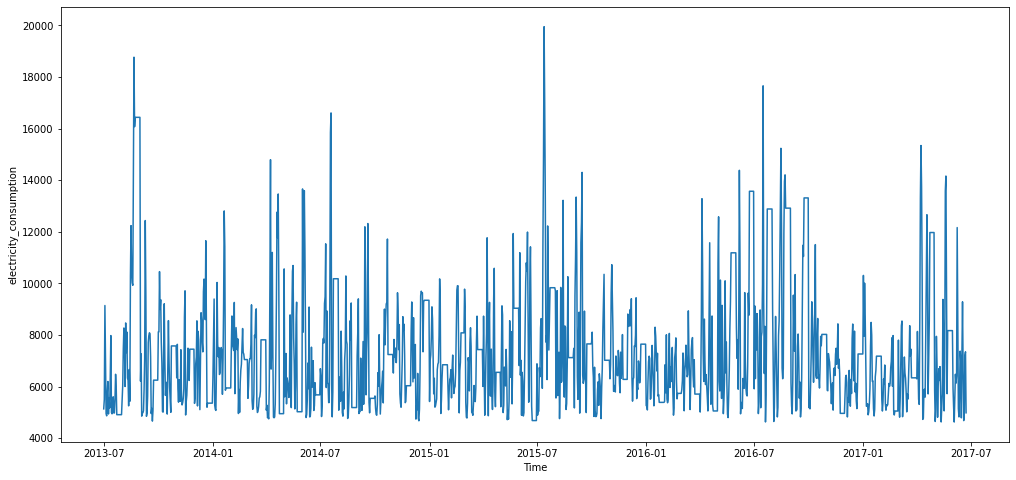

In [85]:
plt.figure(figsize=(17, 8))
plt.plot(df_day['electricity_consumption'])
plt.xlabel('Time')
plt.ylabel('electricity_consumption')
plt.grid(False)
plt.show()

In [86]:
split_time = 1424
x_train = df[:split_time]
x_valid = df[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [87]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [88]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [89]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1, 1), (None, None, 1, 1)), types: (tf.float64, tf.float64)>
(1424, 1)
Epoch 1/100
6/6 [==============================] - 3s 113ms/step - loss: 285.5914 - mae: 286.0914
Epoch 2/100
6/6 [==============================] - 0s 20ms/step - loss: 287.6038 - mae: 288.1038
Epoch 3/100
6/6 [==============================] - 0s 18ms/step - loss: 280.7770 - mae: 281.2770
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 282.1435 - mae: 282.6435
Epoch 5/100
6/6 [==============================] - 0s 21ms/step - loss: 280.8697 - mae: 281.3697
Epoch 6/100
6/6 [==============================] - 0s 18ms/step - loss: 278.8045 - mae: 279.3045
Epoch 7/100
6/6 [==============================] - 0s 22ms/step - loss: 271.2020 - mae: 271.7020
Epoch 8/100
6/6 [==============================] - 0s 20ms/step - loss: 265.3662 - mae: 265.8662
Epoch 9/100
6/6 [==============================] - 0s 19ms/step - loss: 261.8111 - mae: 262.3111
Epoch 10/100
6/6

(1e-08, 0.0001, 0.0, 60.0)

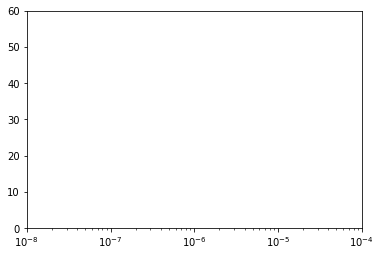

In [91]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 6s 243ms/step - loss: 9.9624 - mae: 10.5789
Epoch 2/150
25/25 [==============================] - 3s 136ms/step - loss: 2.5390 - mae: 3.0130
Epoch 3/150
25/25 [==============================] - 3s 131ms/step - loss: 1.9265 - mae: 2.3815
Epoch 4/150
25/25 [==============================] - 3s 137ms/step - loss: 1.8597 - mae: 2.3125
Epoch 5/150
25/25 [==============================] - 3s 139ms/step - loss: 1.8181 - mae: 2.2696
Epoch 6/150
25/25 [==============================] - 3s 140ms/step - loss: 1.7882 - mae: 2.2385
Epoch 7/150
25/25 [==============================] - 4s 141ms/step - loss: 1.7618 - mae: 2.2112
Epoch 8/150
25/25 [==============================] - 3s 135ms/step - loss: 1.7382 - mae: 2.1870
Epoch 9/150
25/25 [==============================] - 3s 136ms/step - loss: 1.7167 - mae: 2.1650
Epoch 10/150
25/25 [==============================] - 3s 136ms/step - loss: 1.6976 - mae: 2.1454
Epoch 11/150
25/25 [==================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

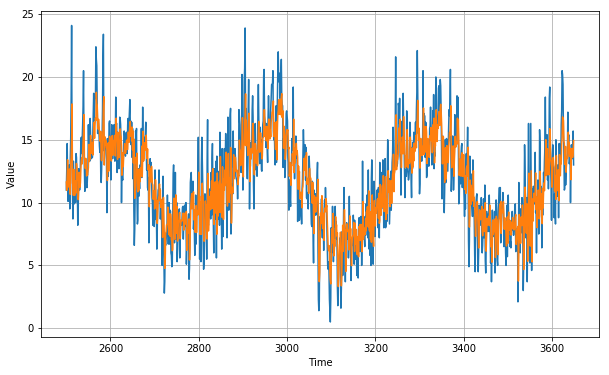

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.780626

In [ ]:
print(rnn_forecast)

[11.636601 10.97607  12.159701 ... 13.589686 13.726407 14.940471]
